# Model Experiments: Tree-Based Classifiers for Churn Prediction

This notebook trains and compares tree-based models against the baseline Logistic Regression.

## Objectives
- Train Random Forest with hyperparameter tuning
- Train Gradient Boosting with hyperparameter tuning
- Use cross-validation for robust evaluation
- Log all experiments to MLflow
- Compare against baseline and select best model

## Success Criteria
- **Target:** AUC-ROC > 0.75 on validation set
- **Baseline to beat:** Logistic Regression AUC-ROC (from Phase 2)

In [1]:
%pip install -e .. --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    make_scorer
)

# Import our custom modules
from src.data_loader import create_sample_data
from src.preprocessing import (
    ChurnPreprocessor, 
    create_train_val_test_split,
    prepare_features_and_target
)
from src.experiment import (
    setup_experiment,
    start_run,
    log_params,
    log_metrics,
    log_classification_metrics,
    log_dataset_info,
    log_model,
    get_best_run
)

# Display settings
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries loaded successfully.")

Libraries loaded successfully.


## 1. Load and Prepare Data

In [3]:
# Generate sample data with realistic correlations
df = create_sample_data(n_samples=1000, random_state=RANDOM_STATE, churn_rate=0.2)

# Split data into train/validation/test sets
train_df, val_df, test_df = create_train_val_test_split(
    df, 
    target_column='churn',
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    random_state=RANDOM_STATE
)

print(f"Dataset shape: {df.shape}")
print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)} (held out)")
print(f"\nChurn rate: {df['churn'].mean():.1%}")

Dataset shape: (1000, 7)
Train: 700, Validation: 150, Test: 150 (held out)

Churn rate: 20.0%


In [4]:
# Initialize preprocessor and fit on training data
preprocessor = ChurnPreprocessor()

# Fit and transform training data
train_preprocessed = preprocessor.fit_transform(train_df, target_column='churn')
X_train, y_train = prepare_features_and_target(train_preprocessed, target_column='churn')

# Transform validation data
val_preprocessed = preprocessor.transform(val_df)
X_val, y_val = prepare_features_and_target(val_preprocessed, target_column='churn')

# Convert to numpy arrays
feature_names = list(X_train.columns)
X_train = X_train.values
X_val = X_val.values
y_train = y_train.values
y_val = y_val.values

print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Features: {feature_names}")

Training features shape: (700, 8)
Validation features shape: (150, 8)
Features: ['tenure', 'monthly_charges', 'total_charges', 'contract_One year', 'contract_Two year', 'payment_method_Credit card', 'payment_method_Electronic check', 'payment_method_Mailed check']


## 2. Set Up MLflow Experiment

In [5]:
# Configure MLflow experiment for model comparison
experiment_name = "churn_prediction_model_comparison"
experiment_id = setup_experiment(experiment_name)

print(f"MLflow Experiment: {experiment_name}")
print(f"Experiment ID: {experiment_id}")

# Store results for comparison
model_results = []

2025/12/26 11:25:54 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/26 11:25:54 INFO mlflow.store.db.utils: Updating database tables
2025/12/26 11:25:54 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/26 11:25:54 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/26 11:25:54 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/26 11:25:54 INFO alembic.runtime.migration: Will assume non-transactional DDL.


MLflow Experiment: churn_prediction_model_comparison
Experiment ID: 2


## 3. Baseline: Logistic Regression (Reference)

In [6]:
# Train baseline Logistic Regression for comparison
with start_run(run_name="logistic_regression_baseline") as run:
    # Train model
    lr_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    lr_model.fit(X_train, y_train)
    
    # Predictions
    y_val_pred = lr_model.predict(X_val)
    y_val_prob = lr_model.predict_proba(X_val)[:, 1]
    
    # Cross-validation score
    cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Log parameters and metrics
    log_params({"model_type": "LogisticRegression", "C": 1.0, "penalty": "l2"})
    val_metrics = log_classification_metrics(y_val, y_val_pred, y_val_prob, prefix="val_")
    log_metrics({"cv_roc_auc_mean": cv_scores.mean(), "cv_roc_auc_std": cv_scores.std()})
    
    lr_run_id = run.info.run_id
    
    model_results.append({
        'model': 'Logistic Regression',
        'run_id': lr_run_id,
        'val_accuracy': val_metrics['val_accuracy'],
        'val_precision': val_metrics['val_precision'],
        'val_recall': val_metrics['val_recall'],
        'val_f1': val_metrics['val_f1_score'],
        'val_roc_auc': val_metrics['val_roc_auc'],
        'cv_roc_auc': cv_scores.mean(),
        'cv_std': cv_scores.std()
    })
    
print(f"Logistic Regression - Val AUC: {val_metrics['val_roc_auc']:.4f}, CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Logistic Regression - Val AUC: 0.9817, CV AUC: 0.9707 (+/- 0.0133)


## 4. Random Forest Classifier

In [7]:
# Define hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Random Forest Hyperparameter Grid:")
for param, values in rf_param_grid.items():
    print(f"  {param}: {values}")

total_combinations = 1
for values in rf_param_grid.values():
    total_combinations *= len(values)
print(f"\nTotal combinations: {total_combinations}")

Random Forest Hyperparameter Grid:
  n_estimators: [50, 100, 200]
  max_depth: [5, 10, 15, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]

Total combinations: 108


In [8]:
# Perform Grid Search with Cross-Validation
print("Running GridSearchCV for Random Forest (this may take a few minutes)...")

rf_base = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

rf_grid_search = GridSearchCV(
    rf_base,
    rf_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {rf_grid_search.best_params_}")
print(f"Best CV AUC: {rf_grid_search.best_score_:.4f}")

Running GridSearchCV for Random Forest (this may take a few minutes)...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best CV AUC: 0.9513


In [9]:
# Log best Random Forest model to MLflow
with start_run(run_name="random_forest_tuned") as run:
    # Get best model
    rf_model = rf_grid_search.best_estimator_
    
    # Predictions
    y_val_pred = rf_model.predict(X_val)
    y_val_prob = rf_model.predict_proba(X_val)[:, 1]
    
    # Log parameters
    log_params({
        "model_type": "RandomForest",
        **rf_grid_search.best_params_
    })
    
    # Log metrics
    val_metrics = log_classification_metrics(y_val, y_val_pred, y_val_prob, prefix="val_")
    log_metrics({
        "cv_roc_auc_mean": rf_grid_search.best_score_,
        "cv_roc_auc_std": rf_grid_search.cv_results_['std_test_score'][rf_grid_search.best_index_]
    })
    
    # Log model
    log_model(rf_model, artifact_path="model")
    
    rf_run_id = run.info.run_id
    
    model_results.append({
        'model': 'Random Forest',
        'run_id': rf_run_id,
        'val_accuracy': val_metrics['val_accuracy'],
        'val_precision': val_metrics['val_precision'],
        'val_recall': val_metrics['val_recall'],
        'val_f1': val_metrics['val_f1_score'],
        'val_roc_auc': val_metrics['val_roc_auc'],
        'cv_roc_auc': rf_grid_search.best_score_,
        'cv_std': rf_grid_search.cv_results_['std_test_score'][rf_grid_search.best_index_]
    })
    
print(f"Random Forest - Val AUC: {val_metrics['val_roc_auc']:.4f}, CV AUC: {rf_grid_search.best_score_:.4f}")

2025/12/26 11:26:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Random Forest - Val AUC: 0.9578, CV AUC: 0.9513


## 5. Gradient Boosting Classifier

In [10]:
# Define hyperparameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'subsample': [0.8, 1.0]
}

print("Gradient Boosting Hyperparameter Grid:")
for param, values in gb_param_grid.items():
    print(f"  {param}: {values}")

total_combinations = 1
for values in gb_param_grid.values():
    total_combinations *= len(values)
print(f"\nTotal combinations: {total_combinations}")

Gradient Boosting Hyperparameter Grid:
  n_estimators: [50, 100, 200]
  learning_rate: [0.01, 0.1, 0.2]
  max_depth: [3, 5, 7]
  min_samples_split: [2, 5]
  subsample: [0.8, 1.0]

Total combinations: 108


In [11]:
# Perform Grid Search with Cross-Validation
print("Running GridSearchCV for Gradient Boosting (this may take a few minutes)...")

gb_base = GradientBoostingClassifier(random_state=RANDOM_STATE)

gb_grid_search = GridSearchCV(
    gb_base,
    gb_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

gb_grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {gb_grid_search.best_params_}")
print(f"Best CV AUC: {gb_grid_search.best_score_:.4f}")

Running GridSearchCV for Gradient Boosting (this may take a few minutes)...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}
Best CV AUC: 0.9545


In [12]:
# Log best Gradient Boosting model to MLflow
with start_run(run_name="gradient_boosting_tuned") as run:
    # Get best model
    gb_model = gb_grid_search.best_estimator_
    
    # Predictions
    y_val_pred = gb_model.predict(X_val)
    y_val_prob = gb_model.predict_proba(X_val)[:, 1]
    
    # Log parameters
    log_params({
        "model_type": "GradientBoosting",
        **gb_grid_search.best_params_
    })
    
    # Log metrics
    val_metrics = log_classification_metrics(y_val, y_val_pred, y_val_prob, prefix="val_")
    log_metrics({
        "cv_roc_auc_mean": gb_grid_search.best_score_,
        "cv_roc_auc_std": gb_grid_search.cv_results_['std_test_score'][gb_grid_search.best_index_]
    })
    
    # Log model
    log_model(gb_model, artifact_path="model")
    
    gb_run_id = run.info.run_id
    
    model_results.append({
        'model': 'Gradient Boosting',
        'run_id': gb_run_id,
        'val_accuracy': val_metrics['val_accuracy'],
        'val_precision': val_metrics['val_precision'],
        'val_recall': val_metrics['val_recall'],
        'val_f1': val_metrics['val_f1_score'],
        'val_roc_auc': val_metrics['val_roc_auc'],
        'cv_roc_auc': gb_grid_search.best_score_,
        'cv_std': gb_grid_search.cv_results_['std_test_score'][gb_grid_search.best_index_]
    })
    
print(f"Gradient Boosting - Val AUC: {val_metrics['val_roc_auc']:.4f}, CV AUC: {gb_grid_search.best_score_:.4f}")

2025/12/26 11:26:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Gradient Boosting - Val AUC: 0.9617, CV AUC: 0.9545


## 6. Model Comparison

In [13]:
# Create comparison dataframe
results_df = pd.DataFrame(model_results)
results_df = results_df.sort_values('val_roc_auc', ascending=False)

print("="*80)
print("MODEL COMPARISON - Sorted by Validation AUC-ROC")
print("="*80)
print(results_df[['model', 'val_roc_auc', 'cv_roc_auc', 'cv_std', 'val_f1', 'val_precision', 'val_recall']].to_string(index=False))
print("="*80)

MODEL COMPARISON - Sorted by Validation AUC-ROC
              model  val_roc_auc  cv_roc_auc   cv_std   val_f1  val_precision  val_recall
Logistic Regression     0.981667    0.970727 0.013297 0.862069       0.892857    0.833333
  Gradient Boosting     0.961667    0.954528 0.016577 0.821429       0.884615    0.766667
      Random Forest     0.957778    0.951339 0.021170 0.821429       0.884615    0.766667


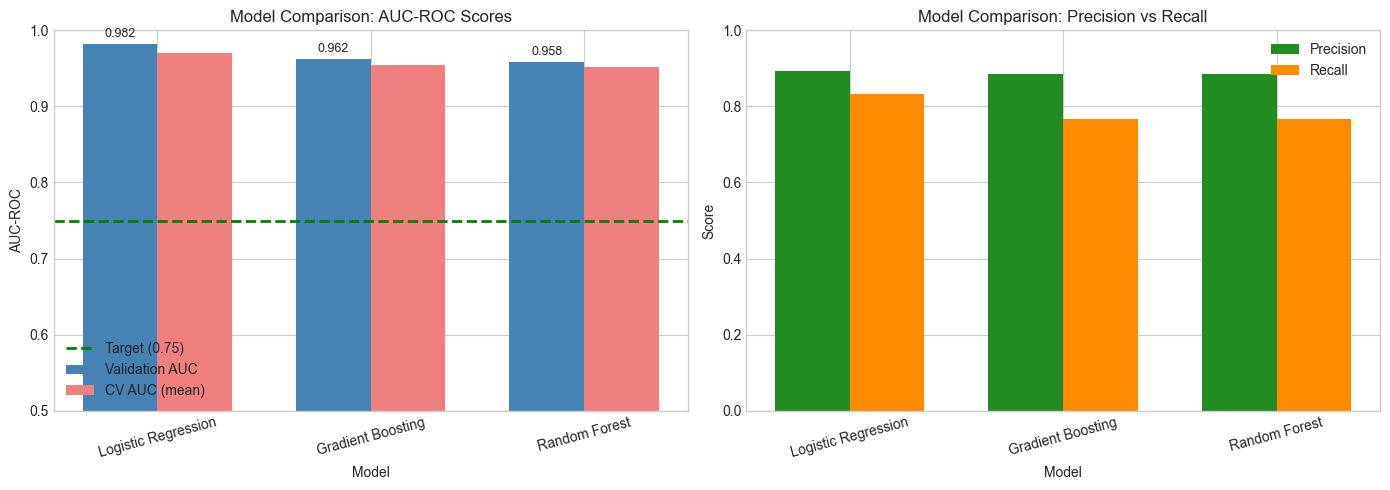

In [14]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# AUC-ROC comparison
ax1 = axes[0]
x = range(len(results_df))
width = 0.35

bars1 = ax1.bar([i - width/2 for i in x], results_df['val_roc_auc'], width, label='Validation AUC', color='steelblue')
bars2 = ax1.bar([i + width/2 for i in x], results_df['cv_roc_auc'], width, label='CV AUC (mean)', color='lightcoral')

ax1.axhline(y=0.75, color='green', linestyle='--', linewidth=2, label='Target (0.75)')
ax1.set_xlabel('Model')
ax1.set_ylabel('AUC-ROC')
ax1.set_title('Model Comparison: AUC-ROC Scores')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df['model'], rotation=15)
ax1.legend()
ax1.set_ylim(0.5, 1.0)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

# Precision/Recall comparison
ax2 = axes[1]
bars3 = ax2.bar([i - width/2 for i in x], results_df['val_precision'], width, label='Precision', color='forestgreen')
bars4 = ax2.bar([i + width/2 for i in x], results_df['val_recall'], width, label='Recall', color='darkorange')

ax2.set_xlabel('Model')
ax2.set_ylabel('Score')
ax2.set_title('Model Comparison: Precision vs Recall')
ax2.set_xticks(x)
ax2.set_xticklabels(results_df['model'], rotation=15)
ax2.legend()
ax2.set_ylim(0, 1.0)

plt.tight_layout()
plt.show()

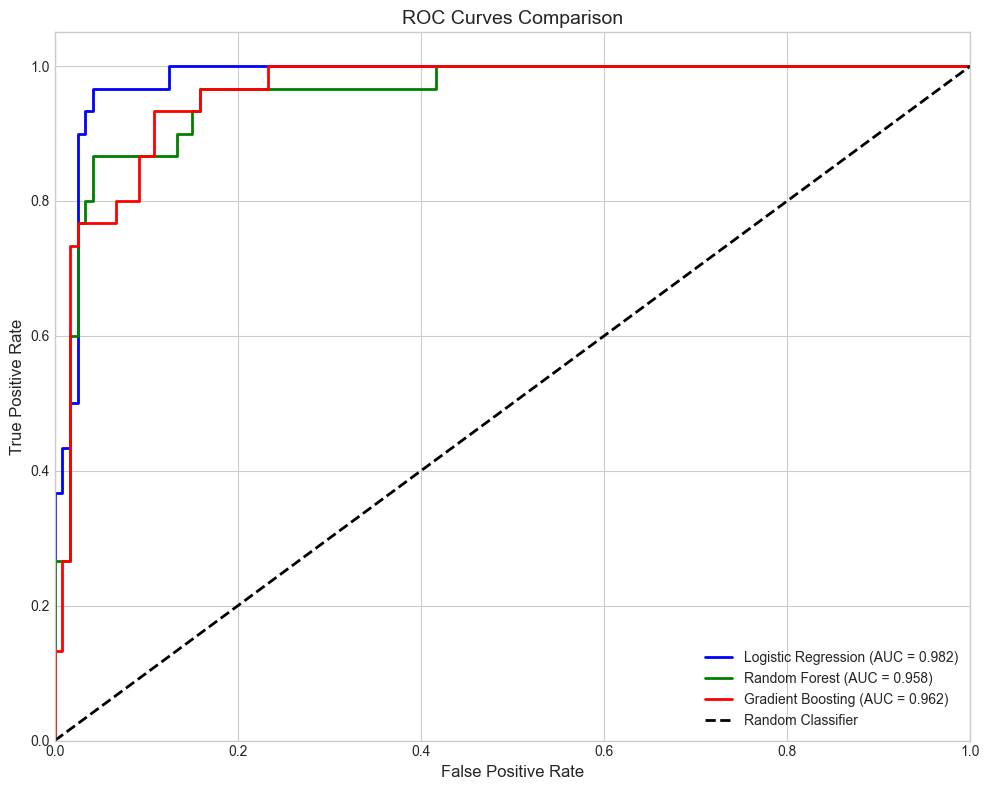

In [15]:
# ROC Curves comparison
fig, ax = plt.subplots(figsize=(10, 8))

models = [
    ('Logistic Regression', lr_model),
    ('Random Forest', rf_model),
    ('Gradient Boosting', gb_model)
]

colors = ['blue', 'green', 'red']

for (name, model), color in zip(models, colors):
    y_prob = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    auc = roc_auc_score(y_val, y_prob)
    ax.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves Comparison', fontsize=14)
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

## 7. Select Best Model

In [16]:
# Determine best model based on validation AUC-ROC
best_model_row = results_df.iloc[0]
best_model_name = best_model_row['model']
best_model_auc = best_model_row['val_roc_auc']
best_run_id = best_model_row['run_id']

# Get the actual model object
if best_model_name == 'Random Forest':
    best_model = rf_model
elif best_model_name == 'Gradient Boosting':
    best_model = gb_model
else:
    best_model = lr_model

print("="*60)
print("BEST MODEL SELECTED")
print("="*60)
print(f"\nModel: {best_model_name}")
print(f"Validation AUC-ROC: {best_model_auc:.4f}")
print(f"MLflow Run ID: {best_run_id}")

# Check against target
target_auc = 0.75
if best_model_auc >= target_auc:
    print(f"\n[PASS] Best model meets target AUC-ROC >= {target_auc}")
else:
    print(f"\n[FAIL] Best model does not meet target AUC-ROC >= {target_auc}")
    print(f"       Need {target_auc - best_model_auc:.4f} improvement")

print("="*60)

BEST MODEL SELECTED

Model: Logistic Regression
Validation AUC-ROC: 0.9817
MLflow Run ID: 8a7973abebc848aca318913d70bc663e

[PASS] Best model meets target AUC-ROC >= 0.75


## 8. Feature Importance Analysis

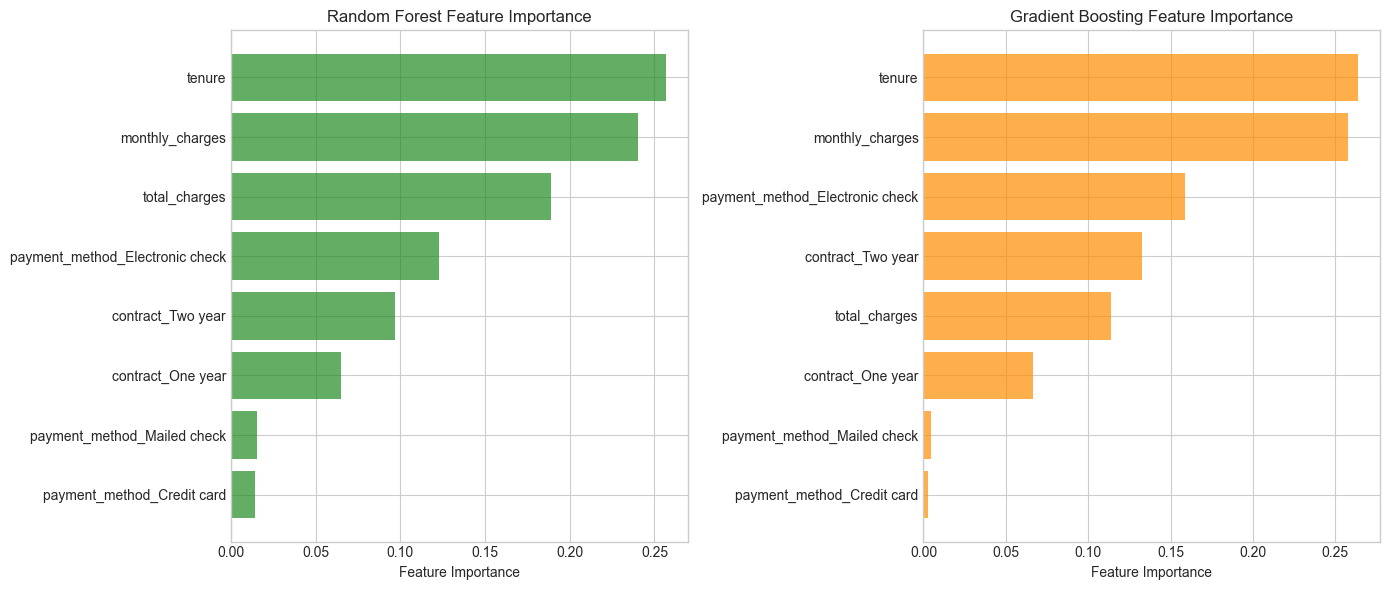

In [17]:
# Get feature importance from tree-based models
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest feature importance
rf_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

ax1 = axes[0]
ax1.barh(rf_importance['feature'], rf_importance['importance'], color='forestgreen', alpha=0.7)
ax1.set_xlabel('Feature Importance')
ax1.set_title('Random Forest Feature Importance')

# Gradient Boosting feature importance
gb_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=True)

ax2 = axes[1]
ax2.barh(gb_importance['feature'], gb_importance['importance'], color='darkorange', alpha=0.7)
ax2.set_xlabel('Feature Importance')
ax2.set_title('Gradient Boosting Feature Importance')

plt.tight_layout()
plt.show()

In [18]:
# Print top features from best model
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop Features for {best_model_name}:")
    print(importance_df.to_string(index=False))
    
    print("\nFeature Importance Insights:")
    top_features = importance_df.head(3)['feature'].tolist()
    print(f"  - Top 3 predictive features: {', '.join(top_features)}")
    print(f"  - These features should align with domain knowledge about churn drivers")

## 9. Summary and Next Steps

In [19]:
# Final summary
print("="*70)
print("PHASE 3 MODEL EXPERIMENTS SUMMARY")
print("="*70)

print("\n--- Models Trained ---")
for _, row in results_df.iterrows():
    print(f"  {row['model']:25s} Val AUC: {row['val_roc_auc']:.4f}  CV AUC: {row['cv_roc_auc']:.4f}")

print(f"\n--- Best Model ---")
print(f"  Model: {best_model_name}")
print(f"  Validation AUC-ROC: {best_model_auc:.4f}")
print(f"  Target (0.75): {'ACHIEVED' if best_model_auc >= 0.75 else 'NOT YET ACHIEVED'}")

print("\n--- Next Steps ---")
print("  1. Evaluate best model on held-out TEST set (one-time evaluation)")
print("  2. Generate final confusion matrix and ROC curve")
print("  3. Document feature importance for stakeholders")
print("  4. Create model card for deployment")

print("\n" + "="*70)

PHASE 3 MODEL EXPERIMENTS SUMMARY

--- Models Trained ---
  Logistic Regression       Val AUC: 0.9817  CV AUC: 0.9707
  Gradient Boosting         Val AUC: 0.9617  CV AUC: 0.9545
  Random Forest             Val AUC: 0.9578  CV AUC: 0.9513

--- Best Model ---
  Model: Logistic Regression
  Validation AUC-ROC: 0.9817
  Target (0.75): ACHIEVED

--- Next Steps ---
  1. Evaluate best model on held-out TEST set (one-time evaluation)
  2. Generate final confusion matrix and ROC curve
  3. Document feature importance for stakeholders
  4. Create model card for deployment

